In [1]:
import os
import sys
from collections import defaultdict
from pathlib import Path
from typing import Dict, List
from zipfile import ZipFile

import IPython
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from scipy import stats
from sklearn.preprocessing import RobustScaler

notebook_path = Path(IPython.extract_module_locals()[1]["__vsc_ipynb_file__"])
project_dir = notebook_path.parent.parent
sys.path.append(str(project_dir))
import src.utils.custom_log as custom_log
import src.utils.json_util as json_util
from src.utils.Csv import Csv
from src.utils.set_rcparams import set_rcparams

os.chdir(project_dir)
LOG = custom_log.init_logger(__name__)
custom_log.set_level(custom_log.LEVELS.DEBUG)
LOG.info("Log initialized")

2024-02-12 21:37:37,843 MainProcess - MainThread INFO Log initialized || 849580755.py


In [2]:
DATA_DIR = Path(r"data\FARS_Data_Raw")

In [3]:
set_rcparams()
PIC_DIR = Path("reports/figures/FARS") / notebook_path.stem
PIC_DIR.mkdir(parents=True, exist_ok=True)
PAGE_WIDTH = 448.13095 / 72

2024-02-12 21:37:37,880 MainProcess - MainThread DEBUG Installed font ['TeX Gyre Adventor', 'TeX Gyre Bonum', 'TeX Gyre Chorus', 'TeX Gyre Cursor', 'TeX Gyre Heros', 'TeX Gyre Heros Cn', 'TeX Gyre Pagella', 'TeX Gyre Schola', 'TeX Gyre Termes'] || set_rcparams.py
2024-02-12 21:37:37,884 MainProcess - MainThread DEBUG Using style src\visualization\dissertation.mplstyle || set_rcparams.py


In [4]:
TRACK_NAMES = ["f", "fm", "m", "mr", "r"]

In [5]:
DUMMY_SIZES = {"HEIGHT":[151.1, 175.3, 186.9], "WEIGHT":[47.3, 77.3, 102.3]}
DUMMY_SIZES["BMI"] = [DUMMY_SIZES["WEIGHT"][i]/((DUMMY_SIZES["HEIGHT"][i]/100)**2) for i in range(3)]
DUMMY_SIZES

{'HEIGHT': [151.1, 175.3, 186.9],
 'WEIGHT': [47.3, 77.3, 102.3],
 'BMI': [20.717255020649368, 25.154498408563068, 29.285795873708654]}

In [6]:
def get_data() -> pd.DataFrame:
    # pre define filter
    rel_cols = {
        "SEAT": [
            "CASEID",
            "PSU",
            "CASENO",
            "CASENUMBER",
            "CATEGORY",
            "VEHNO",
            "SEATLOC",
            "SEATTYPE",
            "ORIENTATION",
            "TRACK",
        ],
        "OCC": [
            "CASEID",
            "PSU",
            "CASENO",
            "CASENUMBER",
            "CATEGORY",
            "VEHNO",
            "OCCNO",
            "SEATLOC",
            "AGE",
            "HEIGHT",
            "WEIGHT",
            "SEX",
            "ROLE",
            "POSTURE",
            "BELTUSE",
            "CHILDSEATUSE",
            "PREGNANT",
            "OBESITY",
            "BMI",
        ],
        "GV": [
            "CASEID",
            "PSU",
            "CASENO",
            "CASENUMBER",
            "CATEGORY",
            "VEHNO",
            "MAKE",
            "MODEL",
            "MODELYR",
            "VEHCLASS",
            "BODYTYPE"
        ],
    }

    # read
    dbs: Dict[str, List[pd.DataFrame]] = defaultdict(list)
    for db_name in rel_cols.keys():
        print(db_name)
        for path in DATA_DIR.glob("CISS*.zip"):
            print(path)
            with ZipFile(path) as archive:
                files = {
                    file.filename.split(".")[0]: file.filename
                    for file in archive.filelist
                }

                with archive.open(files[db_name]) as file:
                    dbs[db_name].append(pd.read_csv(file, usecols=rel_cols[db_name]))
                    if db_name == "SEAT":
                        dbs[db_name][-1] = dbs[db_name][-1].dropna()
        dbs[db_name] = pd.concat(dbs[db_name])

    # merge
    full: pd.DataFrame = dbs["OCC"].merge(
        dbs["SEAT"],
        on=["CASEID", "CASENO", "CASENUMBER", "CATEGORY", "PSU", "SEATLOC", "VEHNO"],
    )

    full = full.merge(dbs["GV"],on=["CASEID", "CASENO", "CASENUMBER", "CATEGORY", "PSU", "VEHNO"],)
    return full


data = get_data()
display(data)

SEAT
data\FARS_Data_Raw\CISS_2017_CSV_FILES.zip
data\FARS_Data_Raw\CISS_2018_CSV_files.zip
data\FARS_Data_Raw\CISS_2019_CSV_files.zip
data\FARS_Data_Raw\CISS_2020_CSV_files.zip
data\FARS_Data_Raw\CISS_2021_CSV_files.zip
OCC
data\FARS_Data_Raw\CISS_2017_CSV_FILES.zip
data\FARS_Data_Raw\CISS_2018_CSV_files.zip
data\FARS_Data_Raw\CISS_2019_CSV_files.zip
data\FARS_Data_Raw\CISS_2020_CSV_files.zip
data\FARS_Data_Raw\CISS_2021_CSV_files.zip
GV
data\FARS_Data_Raw\CISS_2017_CSV_FILES.zip
data\FARS_Data_Raw\CISS_2018_CSV_files.zip
data\FARS_Data_Raw\CISS_2019_CSV_files.zip
data\FARS_Data_Raw\CISS_2020_CSV_files.zip
data\FARS_Data_Raw\CISS_2021_CSV_files.zip


,CASEID,PSU,CASENO,CASENUMBER,CATEGORY,VEHNO,OCCNO,SEATLOC,AGE,HEIGHT,...,OBESITY,BMI,SEATTYPE,ORIENTATION,TRACK,MAKE,MODEL,MODELYR,BODYTYPE,VEHCLASS
0,6035,23,1,1-23-2017-001-04,4,1,1,11,77,168,...,NaN,30.8,1.0,1.0,3.0,55,35,2014,4,3
1,6045,17,1,1-17-2017-001-10,10,1,1,11,42,999,...,NaN,99.9,1.0,1.0,2.0,12,13,1998,4,1
2,6045,17,1,1-17-2017-001-10,10,1,2,13,37,999,...,NaN,99.9,1.0,1.0,2.0,12,13,1998,4,1
3,6042,32,1,1-32-2017-001-09,9,1,1,11,25,160,...,1.0,40.6,1.0,1.0,4.0,54,421,2002,15,15
4,6050,13,1,1-13-2017-001-04,4,1,1,11,36,175,...,NaN,29.7,1.0,1.0,6.0,19,18,2016,4,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29132,21387,22,41,1-22-2021-041-06,6,1,1,11,56,999,...,NaN,99.9,2.0,1.0,5.0,37,31,2012,2,2
29133,22787,15,97,1-15-2021-097-06,6,1,1,11,22,999,...,NaN,99.9,1.0,1.0,9.0,42,42,2013,4,3
29134,23897,29,92,1-29-2021-092-07,7,2,1,11,39,999,...,NaN,99.9,1.0,1.0,5.0,63,402,2012,14,14
29135,23437,26,136,1-26-2021-136-06,6,1,1,11,23,180,...,NaN,23.8,99.0,9.0,9.0,59,34,1999,4,4


In [7]:
def filter_data(db: pd.DataFrame) -> pd.DataFrame:
    db_rel = []
    for cid in db["CASEID"].unique():
        filt = db[db["CASEID"].eq(cid)].copy()

        filt = filt[filt["AGE"].ge(18)] # anly adult occupants
        filt = filt[filt["TRACK"].between(2,6)] # only adjustable seats in known length position
        filt = filt[filt["SEATLOC"].eq(11) | filt["SEATLOC"].eq(13)] # only seats front-left and front-right
        filt = filt[filt["POSTURE"].eq(0)] # only normal posture
        filt = filt[filt["MODEL"].between(1,397)] # only passenger vehicles
        filt = filt[filt["SEX"].isin([1,2]) | filt["PREGNANT"].eq(0)] # only not pregnant

        # passenger must be in vehicle too
        for veh in filt["VEHNO"].unique():
            filt2 = filt[filt["VEHNO"].eq(veh)]
            if 1 in set(filt2["ROLE"]) and 2 in set(filt2["ROLE"]):
                db_rel.append(filt2.copy())

    db_rel = pd.concat(db_rel).set_index(
        ["CASEID", "PSU", "CASENO", "CASENUMBER", "CATEGORY", "VEHNO", "OCCNO"]
    )

    db_rel["ROLE"] = db_rel["ROLE"].replace({1:"Driver", 2:"Passenger"})
    db_rel["TRACK"] = db_rel["TRACK"].replace({i:track_name for i, track_name in enumerate(TRACK_NAMES, 2)})
    db_rel["YEAR"] = [int(x.split("-")[2]) for x in db_rel.index.get_level_values("CASENUMBER")]

    return db_rel

data_filtered = filter_data(db=data)
display(data_filtered)

SEATLOC  AGE  HEIGHT  \
CASEID PSU CASENO CASENUMBER       CATEGORY VEHNO OCCNO                         
6137   33  1      1-33-2017-001-05 5        1     1           11   72     163   
                                                  2           13   28     173   
6131   22  1      1-22-2017-001-02 2        1     1           11   85     172   
                                                  2           13   82     137   
6112   19  5      1-19-2017-005-03 3        2     1           11   51     160   
...                                                          ...  ...     ...   
21617  59  18     1-59-2021-018-05 5        2     2           13   20     178   
22240  48  45     1-48-2021-045-07 7        1     1           11   40     178   
                                                  2           13   36     183   
20369  13  1      1-13-2021-001-04 4        2     1           11   43     173   
                                                  2           13   39     163   

                                                         WEIGHT  SEX  \
CASEID PSU CASENO CASENUMBER       CATEGORY VEHNO OCCNO                
6137   33  1      1-33-2017-001-05 5        1     1          55    2   
                                                  2          64    1   
6131   22  1      1-22-2017-001-02 2        1     1          86    1   
                                                  2          86    2   
6112   19  5      1-19-2017-005-03 3        2     1          51    2   
...                                                         ...  ...   
21617  59  18     1-59-2021-018-05 5        2     2          77    1   
22240  48  45     1-48-2021-045-07 7        1     1          91    1   
                                                  2          82    2   
20369  13  1      1-13-2021-001-04 4        2     1          79    1   
                                                  2          68    2   

                                                              ROLE  POSTURE  \
CASEID PSU CASENO CASENUMBER       CATEGORY VEHNO OCCNO                       
6137   33  1      1-33-2017-001-05 5        1     1         Driver        0   
                                                  2      Passenger        0   
6131   22  1      1-22-2017-001-02 2        1     1         Driver        0   
                                                  2      Passenger        0   
6112   19  5      1-19-2017-005-03 3        2     1         Driver        0   
...                                                            ...      ...   
21617  59  18     1-59-2021-018-05 5        2     2      Passenger        0   
22240  48  45     1-48-2021-045-07 7        1     1         Driver        0   
                                                  2      Passenger        0   
20369  13  1      1-13-2021-001-04 4        2     1         Driver        0   
                                                  2      Passenger        0   

                                                         BELTUSE  \
CASEID PSU CASENO CASENUMBER       CATEGORY VEHNO OCCNO            
6137   33  1      1-33-2017-001-05 5        1     1            0   
                                                  2            4   
6131   22  1      1-22-2017-001-02 2        1     1            4   
                                                  2            4   
6112   19  5      1-19-2017-005-03 3        2     1            0   
...                                                          ...   
21617  59  18     1-59-2021-018-05 5        2     2            0   
22240  48  45     1-48-2021-045-07 7        1     1            4   
                                                  2            4   
20369  13  1      1-13-2021-001-04 4        2     1            4   
                                                  2            4   

                                                         CHILDSEATUSE  \
CASEID PSU CASENO CASENUMBER       CATEGORY VEHNO OCCNO                 
6137   

In [8]:
data_filtered.describe()

,SEATLOC,AGE,HEIGHT,WEIGHT,SEX,POSTURE,BELTUSE,CHILDSEATUSE,PREGNANT,OBESITY,BMI,SEATTYPE,ORIENTATION,MAKE,MODEL,MODELYR,BODYTYPE,VEHCLASS,YEAR
count,1468.000000,1468.000000,1468.000000,1468.000000,1468.000000,1468.0,1468.000000,1468.0,786.0,786.000000,1468.000000,1468.000000,1468.0,1468.000000,1468.000000,1468.000000,1468.000000,1468.000000,1468.000000
mean,12.000000,43.740463,186.008174,104.378747,1.540872,0.0,3.865804,0.0,0.0,0.337150,29.886989,1.125341,1.0,33.538147,32.739782,2011.440054,4.123978,3.212534,2018.510899
std,1.000341,53.746940,115.921358,149.192568,0.498497,0.0,6.243337,0.0,0.0,0.473038,13.828794,0.548243,0.0,16.515900,12.875752,6.111313,0.860968,0.954910,1.219816
min,11.000000,18.000000,134.000000,34.000000,1.000000,0.0,0.000000,0.0,0.0,0.000000,14.200000,1.000000,1.0,2.000000,1.000000,1954.000000,1.000000,1.000000,2017.000000
25%,11.000000,24.000000,163.000000,66.000000,1.000000,0.0,4.000000,0.0,0.0,0.000000,23.400000,1.000000,1.0,20.000000,25.000000,2008.000000,4.000000,3.000000,2018.000000
50%,12.000000,36.000000,169.500000,78.000000,2.000000,0.0,4.000000,0.0,0.0,0.000000,26.800000,1.000000,1.0,35.000000,34.000000,2013.000000,4.000000,3.000000,2018.000000
75%,13.000000,57.000000,178.000000,93.000000,2.000000,0.0,4.000000,0.0,0.0,1.000000,31.525000,1.000000,1.0,49.000000,40.000000,2016.000000,4.000000,4.000000,2019.000000
max,13.000000,999.000000,999.000000,999.000000,2.000000,0.0,99.000000,0.0,0.0,1.000000,99.900000,6.000000,1.0,69.000000,56.000000,2021.000000,6.000000,5.000000,2021.000000


In [10]:
def get_overall_population() -> pd.DataFrame:
    name_sets = [
        ["HEIGHTTC_A", "WEIGHTLBTC_A", "AGEP_A", "SEX_A"],
        ["AHEIGHT", "AWEIGHTP", "AGE_P", "SEX"],
    ]
    end_names = ["HEIGHT", "WEIGHT", "AGE", "SEX"]

    dbs = []
    for path in DATA_DIR.glob("adult*.zip"):
        print(path)
        with ZipFile(path) as archive:
            with archive.open(archive.filelist[0]) as file:
                db = pd.read_csv(file)

        i = 0 if name_sets[0][0] in set(db.columns) else 1
        renamer = {name_sets[i][j]: end_name for j, end_name in enumerate(end_names)}
        db.rename(
            columns=renamer,
            inplace=True,
        )
        db = db[end_names].copy()

        db["HEIGHT"] *= 2.54
        db["WEIGHT"] /= 2.205
        db["BMI"] = db["WEIGHT"] / (db["HEIGHT"] / 100) ** 2
        db["ROLE"] = ["Population US"] * db.shape[0]
        db["YEAR"] = [int(path.stem[5:7]) + 2000] * db.shape[0]

        dbs.append(db.copy())

    dbs = pd.concat(dbs, ignore_index=True)
    return dbs[dbs["WEIGHT"].le(150) & dbs["HEIGHT"].le(210)]


overal_pop = get_overall_population()
overal_pop.describe()

data\FARS_Data_Raw\adult17csv.zip
data\FARS_Data_Raw\adult18csv.zip
data\FARS_Data_Raw\adult19csv.zip
data\FARS_Data_Raw\adult20csv.zip
data\FARS_Data_Raw\adult21csv.zip


,HEIGHT,WEIGHT,AGE,SEX,BMI,YEAR
count,132242.000000,132242.000000,132242.000000,132242.000000,132242.000000,132242.000000
mean,169.568135,80.137524,52.307066,1.536683,27.798268,2019.082304
std,9.894658,17.849785,18.393491,0.498654,5.477747,1.389846
min,149.860000,45.351474,18.000000,1.000000,14.764740,2017.000000
25%,162.560000,66.666667,37.000000,1.000000,23.744064,2018.000000
50%,170.180000,78.458050,53.000000,2.000000,27.041583,2019.000000
75%,177.800000,90.702948,67.000000,2.000000,31.005953,2020.000000
max,193.040000,135.600907,99.000000,2.000000,53.917682,2021.000000


c:\Users\plaschkies\Documents\Py_Projects\aihiii\.conda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\plaschkies\Documents\Py_Projects\aihiii\.conda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\plaschkies\Documents\Py_Projects\aihiii\.conda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


734 734


[None, None]

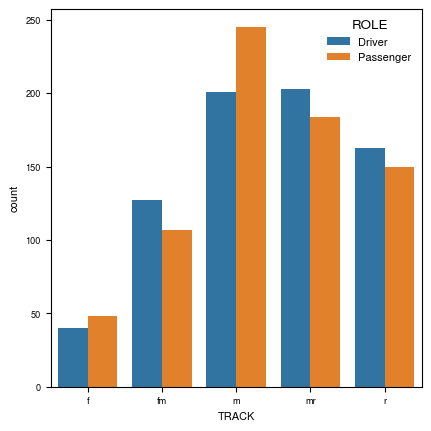

In [15]:
fig, ax = plt.subplots(figsize=(0.7*PAGE_WIDTH, 0.7*PAGE_WIDTH))
sns.countplot(data=data_filtered, x="TRACK", hue="ROLE", order=TRACK_NAMES, ax=ax);
print(data_filtered[data_filtered["ROLE"].eq("Driver")].shape[0], data_filtered[data_filtered["ROLE"].eq("Passenger")].shape[0])
[fig.savefig(PIC_DIR / f"samples_per_track.{suffix}") for suffix in ["png", "pdf"]]

c:\Users\plaschkies\Documents\Py_Projects\aihiii\.conda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\plaschkies\Documents\Py_Projects\aihiii\.conda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\plaschkies\Documents\Py_Projects\aihiii\.conda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\plaschkies\Documents\Py_Projects\aihiii\.conda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is 

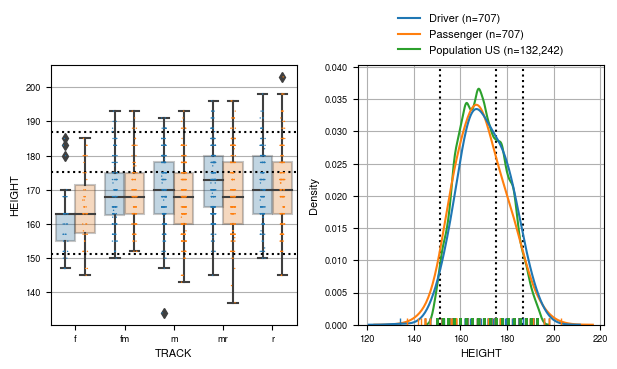

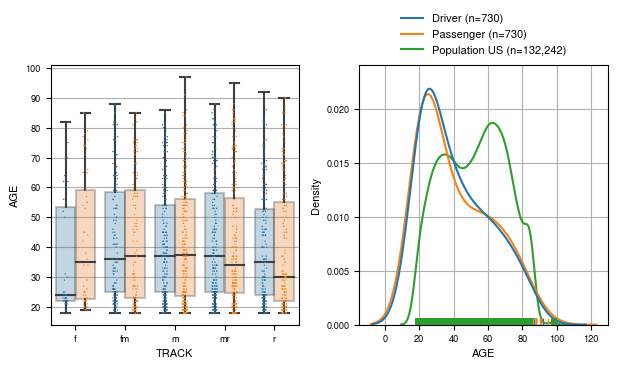

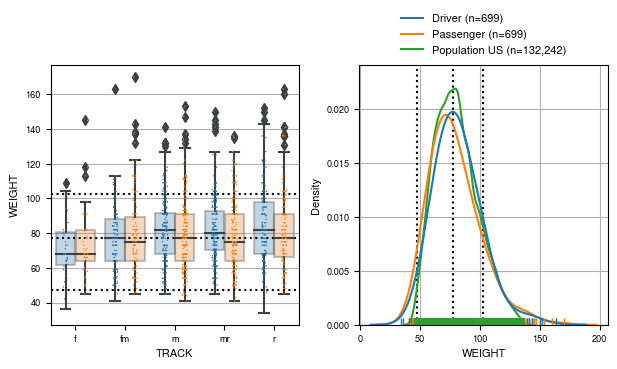

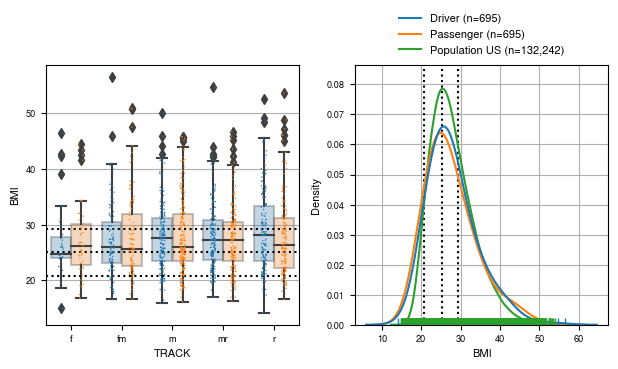

In [28]:
for col in ["HEIGHT", "AGE", "WEIGHT", "BMI"]:
    fig, ax = plt.subplots(ncols=2, figsize=(PAGE_WIDTH, 0.6 * PAGE_WIDTH))

    idxs = []
    for idx in data_filtered[data_filtered[col].ge(90 if col == "BMI" else 900)].index.droplevel("OCCNO"):
        idxs.extend([list(idx) + [i] for i in (1, 2)])
    fi = data_filtered.loc[~data_filtered.index.isin(idxs)].copy()

    sns.boxplot(data=fi, x="TRACK", y=col, hue="ROLE", ax=ax[0], order=TRACK_NAMES, boxprops=dict(alpha=0.3))
    sns.stripplot(data=fi, x="TRACK", y=col, hue="ROLE", ax=ax[0], order=TRACK_NAMES, dodge=True, size=1)
    ax[0].grid(axis="y")
    ax[0].set_axisbelow(True)
    ax[0].legend().remove()

    if col in DUMMY_SIZES:
        for size in DUMMY_SIZES[col]:
            ax[0].axhline(size, c="black", ls=":")
            ax[1].axvline(size, c="black", ls=":")

    fi = pd.concat([fi, overal_pop])
    repl = {role: f"{role} (n={fi[fi['ROLE'].eq(role)].shape[0]:,})" for role in ("Driver", "Passenger", "Population US")}
    fi.replace({"ROLE": repl}, inplace=True)

    sns.kdeplot(data=fi, x=col, hue="ROLE", ax=ax[1], palette=sns.color_palette()[:3], common_norm=False, bw_adjust=1.6)
    g = sns.rugplot(data=fi, x=col, hue="ROLE", ax=ax[1], palette=sns.color_palette()[:3])
    g.legend_.set_title(None)
    sns.move_legend(ax[1], "lower center", bbox_to_anchor=(0.5, 1))  # "upper left", bbox_to_anchor=(1, 1))
    ax[1].grid()
    fig.tight_layout()
    [fig.savefig(PIC_DIR / f"boxplots_{col}.{suffix}") for suffix in ["png", "pdf"]]

In [ ]:
for col in ["HEIGHT", "AGE", "WEIGHT", "BMI"]:
    fig, ax = plt.subplots(ncols=2, figsize=(PAGE_WIDTH, PAGE_WIDTH))

    idxs = []
    for idx in data_filtered[
        data_filtered[col].ge(90 if col == "BMI" else 900)
    ].index.droplevel("OCCNO"):
        idxs.extend([list(idx) + [i] for i in (1, 2)])
    fi = data_filtered.loc[~data_filtered.index.isin(idxs)].copy()

    sns.lineplot(
        data=fi.replace({"TRACK": {u: k for k, u in enumerate(TRACK_NAMES)}}),
        x="TRACK",
        y=col,
        hue="ROLE",
        style="ROLE",
        ax=ax[0],
        estimator="median",
        markers=True,
        dashes=False,
        errorbar=("pi", 95),
    )
    ax[0].set_xticks(range(len(TRACK_NAMES)))
    ax[0].set_xticklabels(TRACK_NAMES)
    ax[0].grid()
    ax[0].set_title("Median & 95% Range")

    if col in DUMMY_SIZES:
        for size in DUMMY_SIZES[col]:
            ax[0].axhline(size, c="black", ls=":")
            ax[1].axvline(size, c="black", ls=":")

    fi = pd.concat([fi, overal_pop])
    repl = {
        role: f"{role} (n={fi[fi['ROLE'].eq(role)].shape[0]:,})"
        for role in ("Driver", "Passenger", "Population US")
    }
    fi.replace({"ROLE": repl}, inplace=True)

    sns.kdeplot(
        data=fi,
        x=col,
        hue="ROLE",
        ax=ax[1],
        palette=sns.color_palette()[:3],
        common_norm=False,
        bw_adjust=1.6,
    )
    g = sns.rugplot(
        data=fi, x=col, hue="ROLE", ax=ax[1], palette=sns.color_palette()[:3]
    )
    ax[1].grid()
    ax[1].set_title("Distribution")
    ax[0].set_ylim([fi[col].min(), fi[col].max()])
    ax[1].set_xlim([fi[col].min(), fi[col].max()])
    fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(15,5), sharex="all", sharey="all")

idxs = []
for idx in  data_filtered[data_filtered["HEIGHT"].ge(900)].index.droplevel("OCCNO"):
    idxs.extend([list(idx) + [i] for i in (1,2)])
fi = data_filtered.loc[~data_filtered.index.isin(idxs)].copy()

for i, role in enumerate(("Driver", "Passenger")):
    fi_2 = fi[fi["ROLE"].eq(role)].copy()
    repl = {track: f"{track} (n={fi_2[fi_2['TRACK'].eq(track)].shape[0]:,})" for track in TRACK_NAMES}
    fi_2.replace({"TRACK":repl}, inplace=True)
    sns.kdeplot(data=fi_2, x="HEIGHT", hue="TRACK", ax=ax[i], hue_order=repl.values(), common_norm=False)
    ax[i].set_title(f"{role} (n={fi_2.shape[0]:,})")
repl = {track: f"{track} (n={fi[fi['TRACK'].eq(track)].shape[0]:,})" for track in TRACK_NAMES}
fi.replace({"TRACK":repl}, inplace=True)
sns.kdeplot(data=fi, x="HEIGHT", hue="TRACK", ax=ax[-1], hue_order=repl.values(), common_norm=False)
ax[-1].set_title(f"Total (n={fi.shape[0]:,})")

for i in range(3):
    ax[i].set_xlim([fi["HEIGHT"].min(), fi["HEIGHT"].max()])
    ax[i].grid()
fig.tight_layout()



In [ ]:
for col in ["HEIGHT", "AGE", "WEIGHT", "BMI"]:
    fig, ax = plt.subplots(ncols=2, figsize=(11, 5))

    idxs = []
    for idx in data_filtered[
        data_filtered[col].ge(90 if col == "BMI" else 900)
    ].index.droplevel("OCCNO"):
        idxs.extend([list(idx) + [i] for i in (1, 2)])
    fi = data_filtered.loc[~data_filtered.index.isin(idxs)].copy()
    fi["Role / Sex"] = [
        f"{fi.loc[idx, 'ROLE']} - {fi.loc[idx, 'SEX']}" for idx in fi.index
    ]
    overal_pop_ = overal_pop[overal_pop["SEX"].isin([1, 2])].copy()
    overal_pop_["Role / Sex"] = [
        f"{overal_pop_.loc[idx, 'ROLE']} - {overal_pop_.loc[idx, 'SEX']}"
        for idx in overal_pop_.index
    ]

    order = sorted(fi["Role / Sex"].unique())

    sns.lineplot(
        data=fi.replace({"TRACK": {u: k for k, u in enumerate(TRACK_NAMES)}}),
        x="TRACK",
        y=col,
        hue="Role / Sex",
        style="Role / Sex",
        ax=ax[0],
        estimator="median",
        markers=True,
        dashes=False,
        errorbar=("pi", 95),
        hue_order=order,
    )
    ax[0].set_xticks(range(len(TRACK_NAMES)))
    ax[0].set_xticklabels(TRACK_NAMES)
    ax[0].grid()
    ax[0].set_title("Median & 95% Range")

    fi = pd.concat([fi, overal_pop_])
    repl = {
        role: f"{role} (n={fi[fi['ROLE'].eq(role)].shape[0]:,})"
        for role in ("Driver", "Passenger", "Population US")
    }
    fi.replace({"ROLE": repl}, inplace=True)

    repl = {}
    order_new = []
    for role_sex in sorted(fi["Role / Sex"].unique()):
        rs = role_sex.split(" - ")
        rs = f"{rs[0]} - {'Male' if rs[1] == '1' else 'Female'}"
        cnt = fi[fi["Role / Sex"].eq(role_sex)].shape[0]
        repl[role_sex] = f"{rs} (n={cnt:,})"
        order_new.append(repl[role_sex])

    # repl = {
    #    track: f"{track} (n={fi[fi['Role / Sex'].eq(track)].shape[0]:,})"
    #    for track in fi["Role / Sex"].unique()
    # }
    fi.replace({"Role / Sex": repl}, inplace=True)

    g = sns.kdeplot(
        data=fi,
        x=col,
        hue="Role / Sex",
        hue_order=order_new,
        ax=ax[1],
        palette=sns.color_palette()[:6],
        common_norm=False,
        bw_adjust=1.7,
    )
    if col in DUMMY_SIZES:
        for size in DUMMY_SIZES[col]:
            ax[0].axhline(size, c="black", ls=":")
            ax[1].axvline(size, c="black", ls=":")
    ax[1].grid()
    ax[1].set_title("Distribution")
    ax[0].set_ylim([fi[col].min(), fi[col].max()])
    ax[1].set_xlim([fi[col].min(), fi[col].max()])

    # legend
    #ax[0].get_legend().remove()
    ax[1].get_legend().set_bbox_to_anchor((1, 1))

    fig.tight_layout()
    break

In [ ]:
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(20, 15), sharex="all", sharey="all")

idxs = []
for idx in data_filtered[data_filtered["HEIGHT"].ge(900)].index.droplevel("OCCNO"):
    idxs.extend([list(idx) + [i] for i in (1, 2)])
fi = data_filtered.loc[~data_filtered.index.isin(idxs)].copy()

for j, sex in enumerate((1, 2)):
    for i, role in enumerate(("Driver", "Passenger")):
        fi_2 = fi[fi["ROLE"].eq(role) & fi["SEX"].eq(sex)].copy()
        repl = {
            track: f"{track} (n={fi_2[fi_2['TRACK'].eq(track)].shape[0]:,})"
            for track in TRACK_NAMES
        }
        fi_2.replace({"TRACK": repl}, inplace=True)
        sns.kdeplot(
            data=fi_2,
            x="HEIGHT",
            hue="TRACK",
            ax=ax[j, i],
            hue_order=repl.values(),
            common_norm=False,
        )
        sns.kdeplot(data=fi_2, x="HEIGHT", ax=ax[j, i], color="black")
        ax[j, i].set_title(
            ("Male" if sex == 1 else "Female") + f" {role} (n={fi_2.shape[0]:,})"
        )

    fi_2 = fi[fi["SEX"].eq(sex)].copy()
    repl = {
        track: f"{track} (n={fi_2[fi_2['TRACK'].eq(track)].shape[0]:,})"
        for track in TRACK_NAMES
    }
    fi_2.replace({"TRACK": repl}, inplace=True)
    sns.kdeplot(
        data=fi_2,
        x="HEIGHT",
        hue="TRACK",
        ax=ax[j, -1],
        hue_order=repl.values(),
        common_norm=False,
    )
    sns.kdeplot(data=fi_2, x="HEIGHT", ax=ax[j, -1], color="black")
    ax[j, -1].set_title(f"Total {'Male' if sex==1 else 'Female'} (n={fi_2.shape[0]:,})")

for i, role in enumerate(("Driver", "Passenger")):
    fi_2 = fi[fi["ROLE"].eq(role)].copy()
    repl = {
        track: f"{track} (n={fi_2[fi_2['TRACK'].eq(track)].shape[0]:,})"
        for track in TRACK_NAMES
    }
    fi_2.replace({"TRACK": repl}, inplace=True)
    sns.kdeplot(
        data=fi_2,
        x="HEIGHT",
        hue="TRACK",
        ax=ax[-1, i],
        hue_order=repl.values(),
        common_norm=False,
    )
    sns.kdeplot(data=fi_2, x="HEIGHT", ax=ax[-1, i], color="black")
    ax[-1, i].set_title(f"Total {role} (n={fi_2.shape[0]:,})")

repl = {
    track: f"{track} (n={fi[fi['TRACK'].eq(track)].shape[0]:,})"
    for track in TRACK_NAMES
}
fi.replace({"TRACK": repl}, inplace=True)
sns.kdeplot(
    data=fi,
    x="HEIGHT",
    hue="TRACK",
    ax=ax[-1, -1],
    hue_order=repl.values(),
    common_norm=False,
)
sns.kdeplot(data=fi, x="HEIGHT", ax=ax[-1, -1], color="black")
ax[-1, -1].set_title(f"Total Total (n={fi.shape[0]:,})")

for i in range(3):
    for j in range(3):
        ax[i, j].set_xlim([fi["HEIGHT"].min(), fi["HEIGHT"].max()])
        ax[i, j].grid()
        ax[i, j].set_xticks(np.arange(140, 201, 5))
fig.tight_layout()

In [ ]:
collector = defaultdict(list)
statis = (
    ("Pearson", stats.pearsonr),
    ("Spearman", stats.spearmanr),
    ("Kendall", stats.kendalltau),
)
scaler = RobustScaler()


for col in ["HEIGHT", "AGE", "WEIGHT", "BMI"]:
    idxs = []
    for idx in data_filtered[
        data_filtered[col].ge(90 if col == "BMI" else 900)
    ].index.droplevel("OCCNO"):
        idxs.extend([list(idx) + [i] for i in (1, 2)])
    fi = data_filtered.loc[~data_filtered.index.isin(idxs)].copy()
    fi.replace(
        {"TRACK": {track: i for i, track in enumerate(TRACK_NAMES)}}, inplace=True
    )

    q1 = fi[col].quantile(0.25)
    q3 = fi[col].quantile(0.75)
    iqr = q3-q1
    fi = fi[fi[col].between(q1-1.5*iqr, q3+1.5*iqr)].copy()



    for role in fi["ROLE"].unique():
        for min_track in ((0, 4), (0, 3), (1, 4), (1, 3)):
            fi2 = fi[fi["ROLE"].eq(role) & fi["TRACK"].between(*min_track)]

            tr_data = fi2["TRACK"]
            col_data = fi2[col]
            for stat_name, method in statis:
                cor = method(tr_data, col_data)

                collector["Method"].append(stat_name)
                collector["Correlation"].append(abs(cor.statistic))
                collector["P-Value"].append(cor.pvalue)
                collector["Role"].append(role)
                collector["Measure"].append(col)
                collector["Count"].append(fi2.shape[0])
                collector["Min Track"].append(str(min_track))

collector = pd.DataFrame(collector)
collector

In [ ]:
fig, ax = plt.subplots(ncols=2, nrows=2, sharex="all", sharey="all", figsize=(7, 7))
for q, mini in enumerate(sorted(collector["Min Track"].unique())):
    i, j = int(q / 2), q % 2
    fi = collector[collector["Method"].eq("Kendall") & collector["Min Track"].eq(mini)]
    sns.barplot(data=fi, x="Measure", y="Correlation", hue="Role", ax=ax[i, j], alpha=0.8)
    mn = eval(mini)
    ax[i, j].set_title(
        f"Track Positions from {TRACK_NAMES[mn[0]]} to {TRACK_NAMES[mn[1]]}"
    )
    ax[i, j].set_ylim(0, 1)
    ax[i, j].grid(axis="y")
    ax[i, j].set_xlabel("")
    ax[i, j].set_yticks(np.arange(0, 1.01, 0.1))
    ax[i, j].set_axisbelow(True)
    if not (i == 0 and j == 0):
        ax[i, j].get_legend().remove()
fig.suptitle("Full Data without Outlier")
fig.tight_layout()


In [ ]:
collector_median = defaultdict(list)
statis = (
    ("Pearson", stats.pearsonr),
    ("Spearman", stats.spearmanr),
    ("Kendall", stats.kendalltau),
)
scaler = RobustScaler()


for col in ["HEIGHT", "AGE", "WEIGHT", "BMI"]:
    idxs = []
    for idx in data_filtered[
        data_filtered[col].ge(90 if col == "BMI" else 900)
    ].index.droplevel("OCCNO"):
        idxs.extend([list(idx) + [i] for i in (1, 2)])
    fi = data_filtered.loc[~data_filtered.index.isin(idxs)].copy()
    fi.replace(
        {"TRACK": {track: i for i, track in enumerate(TRACK_NAMES)}}, inplace=True
    )

    for role in fi["ROLE"].unique():
        for min_track in ((0, 4), (0, 3), (1, 4), (1, 3)):
            fi2 = fi[fi["ROLE"].eq(role) & fi["TRACK"].between(*min_track)]

            tmp = fi2[["HEIGHT", "TRACK"]].groupby("TRACK").median()

            tr_data = tmp.index
            col_data = tmp.values.flatten()
            for stat_name, method in statis:
                cor = method(tr_data, col_data)

                collector_median["Method"].append(stat_name)
                collector_median["Correlation"].append(cor.statistic)
                collector_median["P-Value"].append(cor.pvalue)
                collector_median["Role"].append(role)
                collector_median["Measure"].append(col)
                collector_median["Count"].append(fi2.shape[0])
                collector_median["Min Track"].append(str(min_track))

collector_median = pd.DataFrame(collector_median).fillna(0)
collector_median

In [ ]:
fig, ax = plt.subplots(ncols=2, nrows=2, sharex="all", sharey="all", figsize=(7, 7))
for q, mini in enumerate(sorted(collector_median["Min Track"].unique())):
    i, j = int(q / 2), q % 2
    fi = collector_median[collector_median["Method"].eq("Kendall") & collector_median["Min Track"].eq(mini)]
    sns.barplot(data=fi, x="Measure", y="Correlation", hue="Role", ax=ax[i, j], alpha=0.8)
    mn = eval(mini)
    ax[i, j].set_title(
        f"Track Positions from {TRACK_NAMES[mn[0]]} to {TRACK_NAMES[mn[1]]}"
    )
    ax[i, j].set_ylim(0, 1)
    ax[i, j].grid(axis="y")
    ax[i, j].set_xlabel("")
    ax[i, j].set_yticks(np.arange(0, 1.01, 0.1))
    ax[i, j].set_axisbelow(True)
    if not (i == 0 and j == 0):
        ax[i, j].get_legend().remove()
fig.suptitle("Median")
fig.tight_layout()